### Imports, rc settings, ipython magic commands

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import skimage, skimage.measure
import matplotlib
import pandas as pd

from matplotlib.dates import DateFormatter
from matplotlib.patches import Rectangle

matplotlib.rc('figure', dpi=150)

### Define the coastal HAND function

In [2]:
def coastal_hand_where(src, riv_inun, gage_el_navd88, opix):
    """
    Returns inundation array of the same shape as src.
        Parameters:
            src : ndarray
                2D float array containing terrain elevation data
            gage_el : float
                Constant water surface elevation to apply to DEM
            opix : (int, int)
                Tuple with (row, col) of an ocean cell in src 
    """
    # initialize array with nan values
    src_inun = np.empty_like(src)
    src_inun.fill(np.nan) 
    # where src (the DEM) has an elevation greater than or equal to the gage elev.
    # assign an inundation elev. of 0 to src_inun (array that will become the inundation raster)
    # otherwise assign inundation elev. of gage elev. - DEM surface elevation
    src_inun = np.where(src >= (gage_el_navd88), \
                        0, (gage_el_navd88) - src)
    # masked array with a value of 255 at all inundated cells and 0 at all dry cells
    inun_mask = np.where(src_inun==0,0,255)
    # label connected groups of inundated cells ("blobs")
    blobs = skimage.measure.label(inun_mask)
    # find blob that contains the ocean pixel, which must be inundated
    blob = blobs[opix] # opix is row, col
    # keep only the blob containing the ocean pixel, uninundate all other blobs
    # because they are not hydraulically connected to the ocean
    src_inun = np.where(blobs==blob,src_inun,0) # blobs==1 are cells of biggest blob
    # compound riverine-surge inundation combined with max method
    # src_inun_riv = np.where(src_inun <= riv_inun, riv_inun, src_inun) 
    # return masked array if fed one
    if isinstance(src, np.ma.MaskedArray):
        # src_inun_riv = np.ma.masked_array(src_inun_riv, src.mask)
        src_inun = np.ma.masked_array(src_inun, src.mask)
        
    # mask out zero inundation cells for visualization
    # src_inun_riv = np.ma.masked_where(src_inun_riv==0,src_inun_riv,copy=True)
    
    # return src_inun_riv
    return src_inun

### Read in DEM

In [3]:
# data for initial plot


# 524 MB DEM
with rio.open(r'C:\Users\mkw2538\Coding\si_2022_data\connecticut\dem\ct_roi.tif') as ds_in:
    dem = ds_in.read(1, masked=True)
    in_profile = ds_in.profile
    

# riverine inundation map
# with rio.open('path') as ds_in:
#     inun_riv = ds_in.read(1,masked=True)

### Show DEM with ocean pixel location

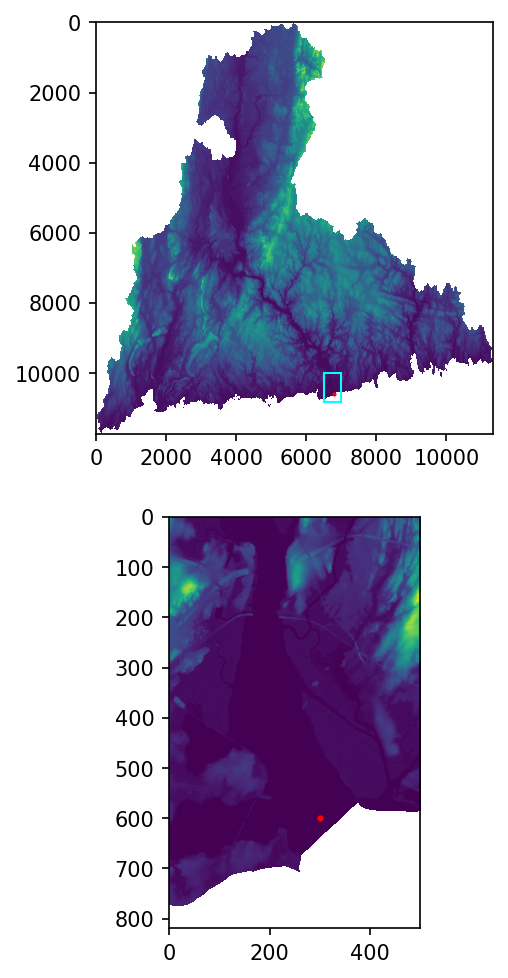

In [4]:
# plot dem, zoom in on coast, find and show ocean pixel

rec_tl = (6500,10000) # x, y
dw, dh = 500,  820 # width, height of rec

opix = (6800,10600) # x, y
opix_col, opix_row = opix
ax1_opix_col, ax1_opix_row = np.subtract(opix,rec_tl)

fig, ax = plt.subplots(2,1,figsize=(6,8))

ax[0].imshow(dem)
ax[0].add_patch(Rectangle(
    rec_tl,
    dw,dh,
    fill=False,
    color='cyan')
    )
ax[0].plot(opix_col, opix_row,'ro',markersize=1) # (x,y) is (col,row)

ax[1].imshow(
    dem[
        rec_tl[1]:rec_tl[1]+dh,
        rec_tl[0]:rec_tl[0]+dw
        ]
        )
ax[1].plot(
    ax1_opix_col, ax1_opix_row,
    'ro',markersize=2
    )

### Set parameters for coastal HAND and run calculation

In [5]:
coast_gage = 5 # 5 meter example
ocean_pixel = opix_row, opix_col # row, col
# inun_surge_riv_compound = coastal_hand_where(dem, inun_riv, coast_gage, ocean_pixel)
inun_surge_10m = coastal_hand_where(dem, None, coast_gage, ocean_pixel)

### Show storm surge inundation map

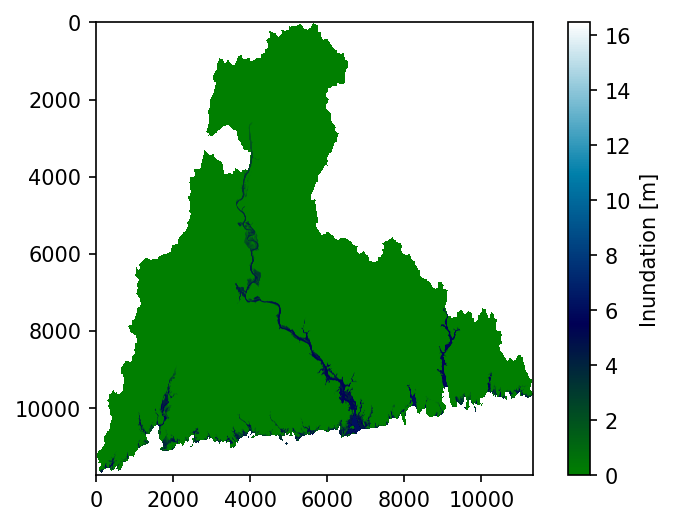

In [6]:
plt.close('all')

fig, ax = plt.subplots()

cbar = ax.imshow(
    inun_surge_10m,
    cmap=plt.get_cmap('ocean')
    )

fig.colorbar(cbar,label='Inundation [m]',ax=ax)

### plot new london and new haven sandy time series

In [13]:
new_london = pd.read_csv(
    r'C:\Users\mkw2538\Coding\si_2022_data' + 
    r'\Sea Water Level\Superstorm Sandy' + 
    r'\CO-OPS_8461490_met_MHHW_new_london.csv',
    parse_dates={'Date & Time': [0,1]}
)

new_london_navd = pd.read_csv(
    r'C:\Users\mkw2538\Coding\si_2022_data' + 
    r'\Sea Water Level\Superstorm Sandy' + 
    r'\CO-OPS_8461490_met.csv',
    parse_dates={'Date & Time': [0,1]}
)

new_haven = pd.read_csv(
    r'C:\Users\mkw2538\Coding\si_2022_data' + 
    r'\Sea Water Level\Superstorm Sandy' + 
    r'\CO-OPS_8465705_met_MHHW_new_haven.csv',
    parse_dates={'Date & Time': [0,1]}
)

In [19]:
plot_dfs = []
dfs = [new_london, new_london_navd, new_haven]
startdate = pd.to_datetime('2012-10-29 12:00')
enddate = pd.to_datetime('2012-10-30 12:00')
for i, df in enumerate(dfs):
    plot_dfs.append(
                     df.loc[
                    (df['Date & Time'] >= startdate) & 
                    (df['Date & Time'] <= enddate)
                    ]
    )

nl_plot, nl_navd_plot, nh_plot = plot_dfs

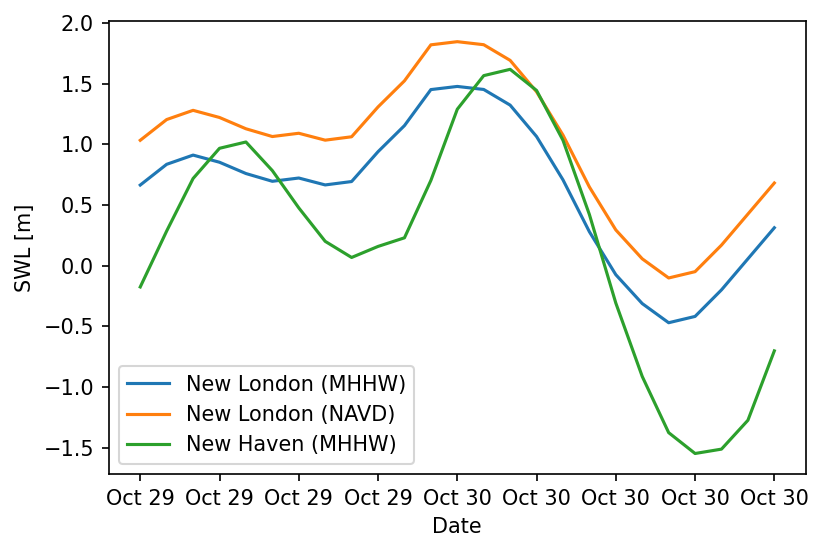

In [20]:
from matplotlib.pyplot import xlabel, xticks, ylabel


plt.close('all')

fig, ax = plt.subplots()

ax.plot(
    nl_plot['Date & Time'],    
    nl_plot['Verified (m)'],
    label='New London (MHHW)'
)

ax.plot(
    nl_navd_plot['Date & Time'],    
    nl_navd_plot['Verified (m)'],
    label='New London (NAVD)'
)

ax.plot(
    nh_plot['Date & Time'],    
    nh_plot['Verified (m)'],
    label='New Haven (MHHW)'
)

# date_form = DateFormatter("%b %d %H:%M")
date_form = DateFormatter("%b %d")
ax.xaxis.set_major_formatter(date_form)
ax.legend()
ax.set(
    xlabel='Date',
    ylabel='SWL [m]'
)
# plt.xticks(rotation=45)

plt.show()

In [85]:
nl_navd_plot

,Date & Time,Predicted (m),Preliminary (m),Verified (m)
12,2012-10-29 12:00:00,0.282,-,1.033
13,2012-10-29 13:00:00,0.399,-,1.204
14,2012-10-29 14:00:00,0.410,-,1.280
15,2012-10-29 15:00:00,0.315,-,1.221
16,2012-10-29 16:00:00,0.172,-,1.128
17,2012-10-29 17:00:00,0.008,-,1.064
18,2012-10-29 18:00:00,-0.185,-,1.091
19,2012-10-29 19:00:00,-0.381,-,1.034
20,2012-10-29 20:00:00,-0.498,-,1.062
21,2012-10-29 21:00:00,-0.474,-,1.308


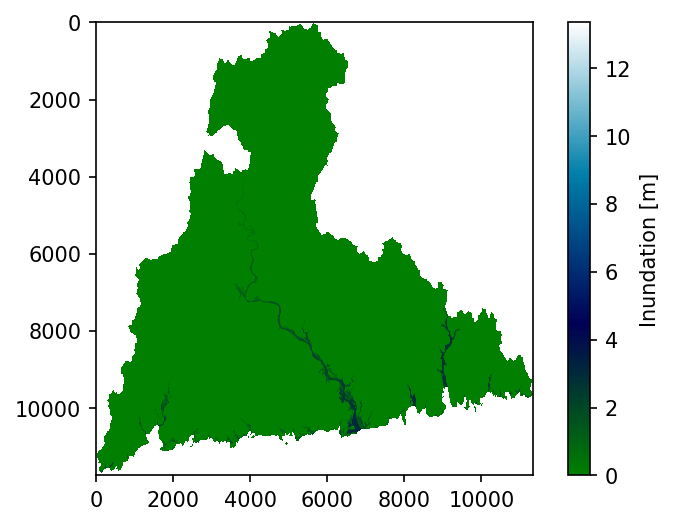

In [ ]:
nl_gage_navd_max = new_london_navd['Verified (m)'].max() # 1.846 meters

inun_surge_nl_navd_max = coastal_hand_where(dem, None, nl_gage_navd_max, ocean_pixel)

plt.close('all')

fig, ax = plt.subplots()

cbar = ax.imshow(
    inun_surge_nl_navd_max,
    cmap=plt.get_cmap('ocean')
    )

fig.colorbar(cbar,label='Inundation [m]',ax=ax)

### Write inundation array to a geotiff raster

In [81]:
msk = (~inun_surge_nl_navd_max.mask * 255).astype('uint8')
with rio.open('connecticut/inun_tiffs/connecticut_surge_nl_navd_max.tif', 'w', **in_profile) as ds_out:
    ds_out.write(inun_surge_nl_navd_max,1)
    ds_out.write_mask(msk)

### Write 24 hour gage data to raster New London 8461490

In [34]:
str(new_london_navd['Date & Time'].iloc[0]).replace(':','.')

'2012-10-29 00.00.00'

In [36]:
for i, swl in enumerate(new_london_navd['Verified (m)']):
    timestamp = str(new_london_navd['Date & Time'].iloc[i]).replace(':','.')
    inun_surge_nl_navd_max = coastal_hand_where(dem, None, swl, ocean_pixel)
    msk = (~inun_surge_nl_navd_max.mask * 255).astype('uint8')
    with rio.open(f'connecticut/inun_tiffs/animation_new_london_gage/{timestamp}.tif', 'w', **in_profile) as ds_out:
        ds_out.write(inun_surge_nl_navd_max,1)
        ds_out.write_mask(msk)
    del(inun_surge_nl_navd_max)

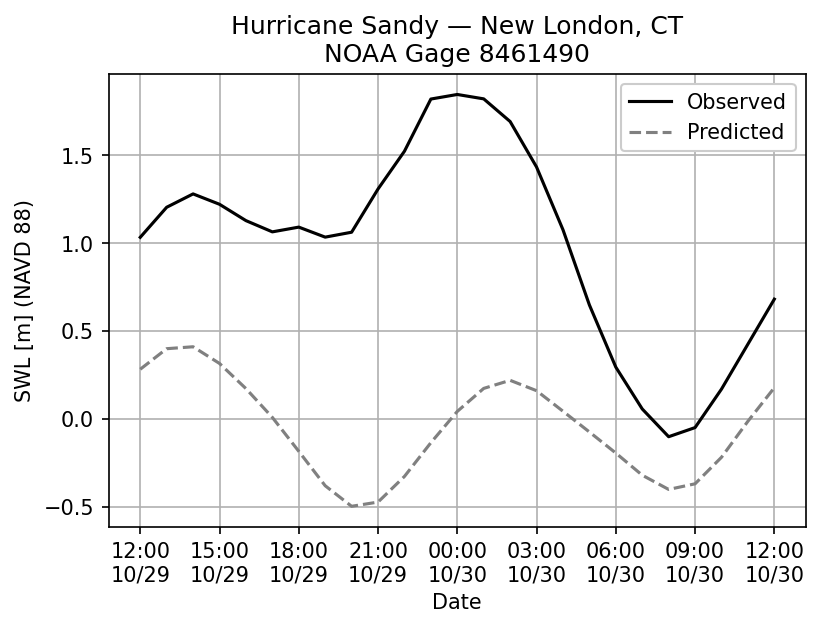

In [84]:
from matplotlib import style


plt.close('all')

fig, ax = plt.subplots()

ax.plot(
    nl_navd_plot['Date & Time'],    
    nl_navd_plot['Verified (m)'],
    'k-',
    label='Observed'
)

ax.plot(
    nl_navd_plot['Date & Time'],    
    nl_navd_plot['Predicted (m)'],
    color='gray',
    linestyle='--',
    label='Predicted'
)

# date_form = DateFormatter("%b %d %H:%M")
date_form = DateFormatter("%H:%M\n%m/%d")
ax.xaxis.set_major_formatter(date_form)
ax.legend(framealpha=1)
ax.set(
    xlabel='Date',
    ylabel='SWL [m] (NAVD 88)',
    title='Hurricane Sandy — New London, CT\nNOAA Gage 8461490'
)
# plt.xticks(rotation=45)
plt.grid()
plt.show()
fig.tight_layout()
# fig.savefig("Sea Water Level/Superstorm Sandy/new_london.png",
#             facecolor='w',
#             dpi=300)

In [65]:
nl_navd_plot.columns

Index(['Date & Time', 'Predicted (m)', 'Preliminary (m)', 'Verified (m)'], dtype='object')